This notebook illustrates how to solve the main stochastic optimal control problem in the paper [Comparative Valuation Dynamics in
Models with Financing Restrictions](https://www.zccfe.uzh.ch/dam/jcr:c4a09093-fc00-4953-9f31-701dc0cd3fab/macro-model-print.pdf) using deep neural networks (DNNs). A comparison with the Macro Finance Research Suite ([MFR Suite](https://mfm.uchicago.edu/software-tools/), which uses finite difference techniques and the high performance parallelized C++ library [Pardiso](https://pardiso-project.org/) for solving large sparse linear systems, is provided.

Below is a brief overview of the problem as well as the main solution techniques involving DNNs.

# Overview of the stochastic optimal control problem


The two types of agents, experts and households, indexed with $j \in \{e,h\}$ face the following maximization problem

\begin{align*}
U_{j,t} &=  \max_{\iota_{j,t}, k_{j,t}, \chi_{j,t}, \theta_{j,t}, c_{j,t} } \mathbb{E} \left[  \int_{0}^{\infty} \varphi_{j}(c_{j,t+s}, U_{j,t+s} | \mathcal{F}_{t}  \right]  \\
& = \max_{\iota_{j,t}, k_{j,t}, \chi_{j,t}, \theta_{j,t}, c_{j,t} } \mathbb{E}_t \left[  \int_{0}^{\infty} 
\rho_{j} \frac{1 - \gamma_j}{1 - \psi_j} U(n_{j,t} , X_{t}) (c^{1 - \psi_j}[(1-\gamma_j)U(n_{j,t} , X_{t})]^{-\frac{1 - \psi_j}{1-\gamma_j}} -1) \right] \tag{1}
\end{align*}
subject to

\begin{align}
& \frac{dn_{j,t}}{n_{j,t}} = (\mu_{n_{j,t}} - c_{j,t}/{n_{j,t}}) dt + \sigma_{n_{j,t}} \cdot dZ_t + \tilde{\sigma}_{n_{j,t}} dZ_{j,t} \tag{2} \\
& dX_{t} = \mu_{X} (X_t) + \sigma_{X} (X_t) dZ_{t}  \tag{3} \\
& \chi_{j,t} \geq \underline{\chi}_{j} \\
& \theta_{j,t} \in \Theta_j \\
& k_{j,t} \geq 0 \\
& n_{j,t} \geq 0 
\end{align}

where 

\begin{align*}
& \mu_{n_{j,t}} = r_t + (q_{t} k_{j,t}/ n_{j,t})(\mu_{R,j,t} - r_{t}) - (1 - \chi_{j,t})(q_{t} k_{j,t}/ n_{j,t}) \sigma_{R,t} \cdot \pi_{t} + \theta_{j,t} \cdot \pi_t \\
& \sigma_{n_{j,t}} = \chi_{j,t} (q_{t} k_{j,t}/ n_{j,t}) \sigma_{R,t} + \theta_{j,t} \\
& \tilde{\sigma}_{n_{j,t}} = \chi_{j,t} (q_{t} k_{j,t}/ n_{j,t}) \sqrt{\varsigma_t} 
%& dX_{t} = \mu_{X} (X_t) + \sigma_{X} (X_t) dZ_{t}
\end{align*}

In the maximization problem above $\iota_{j,t}$ denotes the investment rate, $k_{j,t}$ capital owned by agent $j$ at time $t$, $\chi_{j,t} \in [0,1]$ denotes a fraction of equity held by experts at time $t$, $\theta_{j,t}$ denotes a hedge position in the derivatives markets at time $t$ that pays $\pi_t dt + dZ_t$ per unit of exposure, $c_{j,t}$ denotes consumption at time $t$, and $\{\psi_j, \gamma_j, \rho_j\}$ for $j \in \{e,h\}$ are known parameters representing the inverse intertemporal elasticity of substitution (IES), relative risk aversion, and discount rate (rate of time preference) of each of the two types of agents respectively.

In the budget constraint equation (2) which determines the dynamics of the agents' net worth $\{Z_t\}_{t \geq 0}$ is a $d$-dimensional standard Brownian motion process (hence $\sigma_{R,t} \cdot \pi_{t}$ denotes a vector inner product) and $\{Z_{j,t}\}_{t \geq 0}$ are 1 dimensional Brownian motion processes with $Z_{t}, Z_{e,t}, Z_{h,t}$ independent of each other. 

The state space variables in the economy are $X_t = (w_t, g_t, s_t, \varsigma_t)\in ((0,1) \times \mathbb{R} \times \mathbb{R}_{+} \times \mathbb{R}_{+})$. These variables denote experts' net worth share, expected growth rate of capital, aggregate stochastic variance of capital, and idiosyncratic (for $e$ and $h$) stochastic variance of capital, respectively. The last 3 state variables $g_t, s_t, \varsigma_t$ are exogenously specified as

\begin{align*}
& dg_t = \lambda_g (\overline{g} - g_t) dt  + \sqrt{s_t} \sigma_g \cdot dZ_t \\
& ds_t = \lambda_g (\overline{g} - g_t) dt  + \sqrt{s_t} \sigma_g \cdot dZ_t \\
& d\varsigma_t = \lambda_{\varsigma} (\overline{\varsigma} - \varsigma_t) dt  + \sqrt{\varsigma_t} \sigma_\varsigma{} \cdot dZ_t \\
\end{align*}

Thus, the processes $(g,s,\varsigma)$ are mean-reverting and $s$ and $\varsigma$ are Cox-Ingersoll-Ross (CIR) processes, while the dynamics of $w_t$ defined as $w_t = \int_{j \in J_e} n_{j,t}/(q_t K_t) dj$ are determined in equilibrium. 

The evolution of capital $k_{j,t}$ is given by

\begin{align*}
dk_{j,t} = k_{j,t}[(g_{t} + \iota_{j,t} - \delta) dt  + \sqrt{s_t} \sigma \cdot dZ_t + \sqrt{\varsigma_t} dZ_{j,t}]
\end{align*}

where $g_t, s_t, \varsigma_t$ are the state variables described above and $\delta$ is depreciation. 

The price of capital $q_t$ follows the SDE 

\begin{align*}
dq_t = q_t [\mu_{q,t} dt + \sigma_{q,t} \cdot dZ_t]
\end{align*}

while the return on capital $R_{j,t}^{k}$ follows

\begin{align*}
R_{j,t}^{k} = [\frac{a_j - \Phi(\iota_{j,t}}{q_t} + \iota_{j,t} - \delta + g_t + \mu_{q,t} + \sigma_{K,t} \cdot \sigma_{q,t}]dt + [\sigma_{K,t} + \sigma_{q,t}] \cdot dZ_t + \sqrt{\varsigma} dZ_{j,t}
\end{align*}

Markets are complete and the unique stochastic discount factor (SDF) is defined as 

\begin{align*}
dS_t = -S_t[r_t dt + \pi_t \cdot dZ_t]
\end{align*}

where $r_t$ is the short-term interest rate, and $\pi_t$ denotes the $d \times 1$ vector of risk prices associated with each schock in $Z_t$. 

The utility function is defined as  

\begin{align*}
U_{j,t} (n_{j,t}, X_{t}) = \frac{(\xi_{j}(X_{t}) n_{j,t})^{1 - \gamma_j}}{1-\gamma_{j}} \tag{4}
\end{align*}

for some positive function $\xi_j$.

Using the definition of the budget constraint in (2) and of the utility function $U_{j,t}$ in (4) the associated Hamilton-Jacobi-Bellman equation (HJBE) for the stochastic optimal control problem in (1) (subject to the listed constraints) is given by

\begin{align*}
0 & = \max_{\iota_{j,t}, k_{j,t}, \chi_{j,t}, \theta_{j,t}, c_{j,t} } \varphi_j(c_{j,t}, U_{j,t}) + \mathcal{A} U_{j,t}(n_{j,t}, X_{t}) \\
\end{align*}
Dropping indexes $j$ and $t$ 
\begin{align*}
0 & = \max_{\iota, k, \chi, \theta, c } \varphi(c,U) +  n(\mu_{n} - c/n) \partial_{n} U + \frac{1}{2} n^2( ||\sigma_n ||^2 + \tilde{\sigma}_n^2) \partial_{nn} U + \mu_X \partial_X U + \frac{1}{2} tr(\sigma_{X}' \partial_{XX'} U \sigma_{X})\\ 
\tag{5}
\end{align*}

Using formulas for the derivatives of the utility function $U$ w.r.t. agents' net worth $n_{j,t}$ and the state variables vector $X_t$, along with the first order conditions (FOCs) and corresponding Euler equations, as well as the additional constraints in maximization problem (1), HJBE (5) can be transformed into two HJBEs (please refer to [Appendix A](https://www.zccfe.uzh.ch/dam/jcr:c4a09093-fc00-4953-9f31-701dc0cd3fab/macro-model-print.pdf) of the paper for a derivation of all the steps): one for the households

\begin{equation*}
0 = \frac{\psi_h}{1-\psi_h} \rho_{h}^{1/\psi_h} \xi_{h}^{1-1/\psi_h} - \frac{\rho_h}{1 - \psi_h} + r + \frac{1}{2 \gamma_h}(||\pi||^2 + (\gamma_h \beta_h \sqrt{\varsigma})^2) + \left[\mu_X + \frac{1 - \gamma_h}{\gamma_h} \sigma_X \pi \right] \cdot \partial_X \ln \xi_h + \frac{1}{2} \left[ tr(\sigma^{'}_{X} \partial_{XX'} \ln \xi_h \sigma^{}_{X}) +  \frac{1 - \gamma_h}{\gamma_h} ||\sigma^{'}_{X} \partial_X \ln \xi_h ||^2 \right]
\tag{6}
\end{equation*}

and one for the experts 

\begin{equation*}
0 = \frac{\psi_e}{1-\psi_e} \rho_{e}^{1/\psi_e} \xi_{e}^{1-1/\psi_e} - \frac{\rho_e}{1 - \psi_e} + r + \frac{1}{2 \gamma_e}\frac{(\Delta_e + \pi ⋅ \sigma_R)^2}{||\sigma_R||^2 + \varsigma}  + \left[ \mu_X + \frac{1 - \gamma_e}{ \gamma_e} \frac{(\Delta_e + \pi ⋅ \sigma_R)}{||\sigma_R||^2 + \varsigma} \sigma_R \sigma_X \right] \partial_{X} \ln \xi_e + \frac{1}{2} \left[ tr(\sigma^{'}_{X} \partial_{XX'} \ln \xi_e \sigma^{}_{X}) +  \frac{1 - \gamma_e}{\gamma_e} (\sigma_X' \partial_{X} \ln \xi_e)' \left[ \gamma_e \mathbf{I}_d + (1 - \gamma_e) \frac{\sigma_R \sigma_R'}{||\sigma_R||^2 + \varsigma}\right] \sigma^{'}_{X} \partial_X \ln \xi_e  \right]
\tag{7}
\end{equation*}

Additionally, different constraints in (1) bind in different regions of the state space. The fraction of capital managed by experts defined as $\kappa_t = \frac{K_{e,t}}{K_t}$ (where $K_t$ is total capital in the economy) is used to track which constraints in (1) are binding and to handle the partitioning of the state space due to those constraintss becoming binding. $\kappa_t$ satisfies

\begin{equation*}
0 =  \min \left\{ 1 - \kappa, (1-w) \gamma_e \chi \kappa (||\sigma_R||^2 + \varsigma ) - w \gamma_h (1 - \chi \kappa) ||\sigma_R||^2 - w (1-w)\sigma_{R}^{'} \sigma_{X}^{'} \partial_{X} \ln \left( \frac{\xi_{h}^{\gamma_h -1}}{\xi_{e}^{\gamma_e -1} } \right) \right\} 
\tag{8}
\end{equation*}

# General comments

- Finding an equilibrium requires determining the dynamics of $X$ (specifically the dynamics of the aggregate wealth in the hands of households $w$) and the dynamics of the price of capital $q$, short term interest rate $r$ and risk prices $\pi$ as functions of $X$. The equilibrium then consists of price processes $(q_t, r_t, \pi_t)$ which the agents take as given and use to solve their optimization problems leading to allocation processes $(\iota_{j,t}, k_{j,t}, \chi_{j,t}, \theta_{j,t}, c_{j,t})$ subject to market clearing conditions (equations (17) to (20) in the [paper](https://www.zccfe.uzh.ch/dam/jcr:c4a09093-fc00-4953-9f31-701dc0cd3fab/macro-model-print.pdf) ) 

- The two HJBEs for $j \in \{e,h\}$ are de-coupled

# The deep neural network (DNN) approach for a 3D model

Note that we are solving a model in 3 state variables with $\varsigma = 0$ everywhere so equations (6), (7) and (8) as well as all other equations involving $\varsigma$ need to be updated accordingly.

The idea behind the DNN approach is to approximate the functions $\ln \xi_h$, $\ln \xi_e$ in the non-linear, high-dimensional PDEs (6) and (7) and $\kappa$ in the ODE wrapped inside a min operator (8) with neural networks. To do so we define a separate DNN for each of the 3 functions and train it to minimize the mean squared error (MSE) of its corresponding equation (6), (7) or (8), where the MSE is minimized over a 3 dimensional grid of uniformly sampled points in the domain of each state variable $ w, s, g$. DNNs with different architectures - size and type of activation units - can provide accurate approximations but for $\kappa$ we must always use a sigmoid activation function in the final output unit since $\kappa$ is the ratio of capital in the hands of experts and consequently can only take on values in the range [0,1]. In this notebook we use DNNs of size 4 hidden layers with 16 neurons and $\tanh(x)$ activations functions (for a total of 897 trainable parameters in each DNN).

Note that we are approximating $\ln \xi_e$ and $\ln \xi_h$ rather than $\xi_e$ and $\xi_h$. This is because functions $\xi_e$ and $\xi_h$ in HJBEs (6) and (7) need to be positive and when linear activation functions are used in the last output units of the DNNs the approximating functions will not be positive. This can be overcome by re-writing HJBEs (6) and (7) in terms of $\xi_e$ and $\xi_h$. 

Training of the neural networks is done very differently than the standard deep learning approach in the sense that we do not use a batch training algorithm such as stochastic gradient descent (SGD) or Adam or any of the many batch (online) training algorithms available but instead apply a global training procedure which minimizes the MSE over the the whole approximation grid (full batch training). The algorithm used is the [limited memory BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) method, a quasi-Newton technique which uses a sparse approximation of the Hessian matrix.



# Code

Change the the path in `folderName` below to the folder where you have downloaded the repo.

In [4]:
folderName               = 'drive/My Drive/current/BFI/MFR/defaultModel_hh_prod_nonlog/Github'

In [5]:
## Import libraries
import tensorflow as tf 
from tensorflow import keras

import time
import sys
import os

import numpy as np
import pickle 
from tqdm import trange

# Import BFGS optimizer
from scipy import optimize

## Plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Import helper functions
sys.path.insert(0,folderName) ## Change this to the folder where you have donwloaded the repo
import helper_functions

!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-f92d5fc4-293c-9a28-268d-50c3aab562fa)


## Model Parameters

Since we are performing a comparison with the MFR Suite we can read in the parameters of the economic model from the `parameters.json` file which the MFR Suite outputs. These includes all exogenous parameters such as $\{\psi_j, \gamma_j, \rho_j\}$ for $j \in \{e,h\}$ which, as expalined in the overview, represent the inverse intertemporal elasticity of substitution (IES), relative risk aversion, and discount rate (rate of time preference) of each of the two types of agents, as well as the mean expected growth of capital $\bar{g}$. 

A slight change of notation is used in the code for the state variables: $w$ is denoted by `W`,  $g$ is denoted by `Z`, and $s$ is denoted by `V` ($\varsigma$ is denoted by `Vtilde` but recall that we are working with a 3 dimensional model and consequently `Vtilde` will be always equal to 0).    

In [ ]:
folderName               = 'drive/My Drive/current/BFI/MFR/defaultModel_hh_prod_nonlog'

import json
import tensorflow as tf
json_location =  folderName + '/parameters.json'

with open(json_location) as json_file:
  paramsFromFile= json.load(json_file)

def setModelParametersFromFile(paramsFromFile):

  params = {}
  ####### Model parameters #######
  params['nu_newborn']             = tf.constant(paramsFromFile['nu_newborn'],         dtype=tf.float64);
  params['lambda_d']               = tf.constant(paramsFromFile['lambda_d'],           dtype=tf.float64);
  params['lambda_Z']               = tf.constant(paramsFromFile['lambda_Z'],           dtype=tf.float64);
  params['lambda_V']               = tf.constant(paramsFromFile['lambda_V'],           dtype=tf.float64);
  params['lambda_Vtilde']          = tf.constant(paramsFromFile['lambda_Vtilde'],      dtype=tf.float64);
  params['Vtilde_bar']             = tf.constant(paramsFromFile['Vtilde_bar'],         dtype=tf.float64);
  params['Z_bar']                  = tf.constant(paramsFromFile['Z_bar'],              dtype=tf.float64);
  params['V_bar']                  = tf.constant(paramsFromFile['V_bar'],              dtype=tf.float64);
  params['a_e']                    = tf.constant(paramsFromFile['a_e'],                dtype=tf.float64);
  params['a_h']                    = tf.constant(paramsFromFile['a_h'],                dtype=tf.float64);  ###Any negative number means -infty
  params['phi']                    = tf.constant(paramsFromFile['phi'],                dtype=tf.float64);
  params['gamma_e']                = tf.constant(paramsFromFile['gamma_e'],            dtype=tf.float64);
  params['gamma_h']                = tf.constant(paramsFromFile['gamma_h'],            dtype=tf.float64);
  params['psi_e']                  = tf.constant(paramsFromFile['rho_e'],              dtype=tf.float64);  ### Mismatch btw paper and MFR notation
  params['psi_h']                  = tf.constant(paramsFromFile['rho_h'],              dtype=tf.float64);  ### Mismatch btw paper and MFR notation
  params['rho_e']                  = tf.constant(paramsFromFile['delta_e'],            dtype=tf.float64); 
  params['rho_h']                  = tf.constant(paramsFromFile['delta_h'],            dtype=tf.float64);  
  params['sigma_K_norm']           = tf.constant(paramsFromFile['sigma_K_norm'],       dtype=tf.float64);
  params['sigma_Z_norm']           = tf.constant(paramsFromFile['sigma_Z_norm'],       dtype=tf.float64);
  params['sigma_V_norm']           = tf.constant(paramsFromFile['sigma_V_norm'],       dtype=tf.float64);
  params['sigma_Vtilde_norm']      = tf.constant(paramsFromFile['sigma_Vtilde_norm'],  dtype=tf.float64);
  params['equityIss']              = tf.constant(paramsFromFile['equityIss'],          dtype=tf.float64);
  params['chiUnderline']           = tf.constant(paramsFromFile['chiUnderline'],       dtype=tf.float64);
  params['delta']                  = tf.constant(paramsFromFile['alpha_K'],              dtype=tf.float64);


  params['cov11']                  = tf.constant(paramsFromFile['cov11'],              dtype=tf.float64);
  params['cov12']                  = tf.constant(paramsFromFile['cov12'],              dtype=tf.float64);
  params['cov13']                  = tf.constant(paramsFromFile['cov13'],              dtype=tf.float64);
  params['cov14']                  = tf.constant(paramsFromFile['cov14'],              dtype=tf.float64);

  params['cov21']                  = tf.constant(paramsFromFile['cov21'],              dtype=tf.float64);
  params['cov22']                  = tf.constant(paramsFromFile['cov22'],              dtype=tf.float64);
  params['cov23']                  = tf.constant(paramsFromFile['cov23'],              dtype=tf.float64);
  params['cov24']                  = tf.constant(paramsFromFile['cov24'],              dtype=tf.float64);

  params['cov31']                  = tf.constant(paramsFromFile['cov31'],              dtype=tf.float64);
  params['cov32']                  = tf.constant(paramsFromFile['cov32'],              dtype=tf.float64);
  params['cov33']                  = tf.constant(paramsFromFile['cov33'],              dtype=tf.float64);
  params['cov34']                  = tf.constant(paramsFromFile['cov34'],              dtype=tf.float64);

  params['cov41']                  = tf.constant(paramsFromFile['cov41'],              dtype=tf.float64);
  params['cov42']                  = tf.constant(paramsFromFile['cov42'],              dtype=tf.float64);
  params['cov43']                  = tf.constant(paramsFromFile['cov43'],              dtype=tf.float64);
  params['cov44']                  = tf.constant(paramsFromFile['cov44'],              dtype=tf.float64);

  params['numSds']                 = tf.constant(paramsFromFile['numSds'],             dtype=tf.float64);

  ########### Derived parameters
  ## Covariance matrices 
  params['sigmaK']                 = tf.concat([params['cov11'] * params['sigma_K_norm'], 
                                                      params['cov12'] * params['sigma_K_norm'],
                                                      params['cov13'] * params['sigma_K_norm'],
                                                      params['cov14'] * params['sigma_K_norm']], 0)

  params['sigmaZ']                 = tf.concat([params['cov21'] * params['sigma_Z_norm'], 
                                                      params['cov22'] * params['sigma_Z_norm'],
                                                      params['cov23'] * params['sigma_Z_norm'],
                                                      params['cov24'] * params['sigma_Z_norm']], 0)

  params['sigmaV']                 = tf.concat([params['cov31'] * params['sigma_V_norm'], 
                                                      params['cov32'] * params['sigma_V_norm'],
                                                      params['cov33'] * params['sigma_V_norm'],
                                                      params['cov34'] * params['sigma_V_norm']], 0)
  
  ## Min and max of state variables
  ## min/max for V
  shape = 2 * params['lambda_V'] * params['V_bar']  /   (tf.pow(params['sigma_V_norm'],2));
  rate = 2 * params['lambda_V'] / (tf.pow(params['sigma_V_norm'],2));
  params['vMin'] = tf.constant(0.00001, dtype=tf.float64)

  
  params['vMax'] = params['V_bar'] + params['numSds'] * tf.sqrt( shape / tf.pow(rate, 2));

  ## min/max for Z
  zVar  = tf.pow(params['V_bar'] * params['sigma_Z_norm'], 2) / (2 * params['lambda_Z'])
  params['zMin'] = params['Z_bar'] - params['numSds'] * tf.sqrt(zVar)
  params['zMax'] = params['Z_bar'] + params['numSds'] * tf.sqrt(zVar)

  ## min/max for W
  params['wMin'] = tf.constant(0.01, dtype=tf.float64)
  params['wMax'] = tf.constant(1 - params['wMin'], dtype=tf.float64)

  return params

params = setModelParametersFromFile(paramsFromFile)

In [ ]:
print('Experts equity retention constraint (equityIss):', params['equityIss'].numpy()) ## 1: equity ret. is chiUnderline everywhere; 2: equity ret. is bounded below by chiUnderline

print('Productivity of experts (a_e): \t\t\t',            params['a_e'].numpy())
print('Productivity of households (a_h): \t\t',           params['a_h'].numpy())

print('Relative risk aversion of experts (psi_e): \t',    params['psi_e'].numpy())
print('Relative risk aversion of households (psi_h): \t', params['psi_h'].numpy())

## Uncomment the two lines below to see all parameters. 
## (Note that some parameters are associated with the solution alogrithm in the MFR Suite
## e.g. ``innerTol`` is the tolerance treshhold for the inner loop of the numerical solution 
## algorithm described in Appendix B of the paper and implemented in the MFR Suite. For 
## a complete listing of all MFR Suite parameters refer to the README.pdf file included
## in the MFR distribution files)

# for key, item in paramsFromFile.items():
#   print('params[\'' + key + '\']' + '\t\t= ' + str(item))

Experts equity retention constraint (equityIss): 2.0
Productivity of experts (a_e): 			 0.14
Productivity of households (a_h): 		 0.135
Relative risk aversion of experts (psi_e): 	 1.5
Relative risk aversion of households (psi_h): 	 1.5


## Functions



### Loss function

The loss functions below encode equtions (6), (7) and (8) and reference all intermediary results (equations) from the paper typicall with comments of the form of `######` follow by the equation number e.g. `###### eq. (68)`.

The code for the functions below can be refactored and combined into a single loss function which returns the respective loss based on a logical statement but the functions are presented separately for readability.

In [ ]:
@tf.function 
def HJB_loss_E(valueFunctionLogH, valueFunctionLogE, constraintsFunctionKappa, W, Z, V, params):
    """ A function to compute the Hamilton-Jacobi-Bellman equation error associated with the 
    experts HJBE (7)
  Args:
      valueFunctionLogH        [in]: an instance of `tf.keras.Model` or its subclasses (DNN which approximates ln\xi_H in eq (6))
      valueFunctionLogE        [in]: an instance of `tf.keras.Model` or its subclasses (DNN which approximates ln\xi_E in eq (7))
      constraintsFunctionKappa [in]: an instance of `tf.keras.Model` or its subclasses (DNN which approximates \kappa  in eq (8))
      W                        [in]: a tensor of random points in [wMin, wMax] (experts' net worth share)
      Z                        [in]: a tensor of random points in [zMin, zMax] (expected growth rate of capital)
      V                        [in]: a tensor of random points in [vMin, vMax] (aggregate stochastic variance of capital)
      params                   [in]: a dictionary containing the economic parameters for the model
  Returns:
      A tensor which denotes the loss in HJBE (7) at each point in (W,Z,V)
  """
  X = tf.concat([W,Z,V], axis=1)
  

  ## Parse information
  nShocks      = params['sigmaK'].shape[0]
  nStates      = X.shape[1]
  batchSize    = X.shape[0]

  ## Value functions and kappa
  logXiE       = valueFunctionLogE(X)
  logXiH       = valueFunctionLogH(X)
  xiE          = tf.exp(logXiE)
  xiH          = tf.exp(logXiH)

  if params['a_h'] > 0:
    kappa        = tf.reshape(constraintsFunctionKappa(X), [batchSize, 1] )
  else:
    kappa        = tf.ones([batchSize,1], dtype=tf.float64)

  num_q          = (1 - kappa) * params['a_h'] + kappa * params['a_e'] + 1 / params['phi']
  den_q          = (1 - W) * tf.pow(params['rho_h'], 1 / params['psi_h']) \
  * tf.pow(xiH, 1 - 1 / params['psi_h']) + W * tf.pow(params['rho_e'], 1 / params['psi_e']) \
  * tf.pow(xiE, 1 - 1 / params['psi_e']) + 1 / params['phi']
  Q              = num_q / den_q     ##### eq. (44)
  logQ           = tf.math.log(Q)

  ### Derivatives
  ## First order
  dW_logQ                = tf.gradients(logQ, W)[0]
  dZ_logQ                = tf.gradients(logQ, Z)[0]
  dV_logQ                = tf.gradients(logQ, V)[0]

  dW_Q                   = tf.gradients(Q, W)[0]
  dZ_Q                   = tf.gradients(Q, Z)[0]
  dV_Q                   = tf.gradients(Q, V)[0]

  dW_logXiH              = tf.gradients(logXiH, W)[0]
  dZ_logXiH              = tf.gradients(logXiH, Z)[0]
  dV_logXiH              = tf.gradients(logXiH, V)[0]
  
  dW_logXiE              = tf.gradients(logXiE, W)[0]
  dZ_logXiE              = tf.gradients(logXiE, Z)[0]
  dV_logXiE              = tf.gradients(logXiE, V)[0]
  # #### Second order
  # dW2_logQ               = tf.gradients(dW_logQ, W)[0]
  # dZ2_logQ               = tf.gradients(dZ_logQ, Z)[0]
  # dV2_logQ               = tf.gradients(dV_logQ, V)[0]

  ## logXiE
  dW2_logXiE             = tf.gradients(dW_logXiE, W)[0]
  dZ2_logXiE             = tf.gradients(dZ_logXiE, Z)[0]
  dV2_logXiE             = tf.gradients(dV_logXiE, V)[0]
  ## Cross derivatives (for correlated shocks)
  # dWdZ_logXiE            = tf.gradients(dW_logXiE, Z)[0]
  # dWdV_logXiE            = tf.gradients(dW_logXiE, V)[0]
  # dZdV_logXiE            = tf.gradients(dZ_logXiE, V)[0]
  
  ## logXiH
  dW2_logXiH             = tf.gradients(dW_logXiH, W)[0]
  dZ2_logXiH             = tf.gradients(dZ_logXiH, Z)[0]
  dV2_logXiH             = tf.gradients(dV_logXiH, V)[0]
  # ## Cross derivatives (for correlated shocks)
  # dWdZ_logXiH            = tf.gradients(dW_logXiH, Z)[0]
  # dWdV_logXiH            = tf.gradients(dW_logXiH, V)[0]
  # dZdV_logXiH            = tf.gradients(dZ_logXiH, V)[0]

  ## Q
  dW2_Q                  = tf.gradients(dW_Q, W)[0]
  dZ2_Q                  = tf.gradients(dZ_Q, Z)[0]
  dV2_Q                  = tf.gradients(dV_Q, V)[0]
  # ## Cross derivatives (for correlated shocks)
  # dWdZ_Q                 = tf.gradients(dW_Q, Z)[0]
  # dWdV_Q                 = tf.gradients(dW_Q, V)[0]
  # dZdV_Q                 = tf.gradients(dZ_Q, V)[0]

  ## Combine derivatives 
  dX_logQ                 = tf.concat([dW_logQ, dZ_logQ, dV_logQ], axis=1)
  # dX2_logQ                = tf.concat([dW2_logQ, dZ2_logQ, dV2_logQ], axis=1)
  dX_Q                    = tf.concat([dW_Q, dZ_Q, dV_Q], axis=1)
  dX2_Q_diag              = tf.concat([dW2_Q, dZ2_Q, dV2_Q], axis=1)
  dX_LogXiE               = tf.concat([dW_logXiE, dZ_logXiE, dV_logXiE], axis=1)
  dX2_LogXiE              = tf.concat([dW2_logXiE, dZ2_logXiE, dV2_logXiE], axis=1)
  dX_LogXiH               = tf.concat([dW_logXiH, dZ_logXiH, dV_logXiH], axis=1)
  dX2_LogXiH              = tf.concat([dW2_logXiH, dZ2_logXiH, dV2_logXiH], axis=1)

  ## Compute drifts and volatilities. For now, assume no idio vol (\varsigma = 0 everywhere)
  sigmaK       = params['sigmaK'] * tf.sqrt(V)
  sigmaZ       = params['sigmaZ'] * tf.sqrt(V)
  sigmaV       = params['sigmaV'] * tf.sqrt(V)
  
  muZ          = params['lambda_Z'] * (params['Z_bar'] - Z) ###### eq.  (53)
  muV          = params['lambda_V'] * (params['V_bar'] - V) ###### eq.  (53)

  ## Compute equilibrium objects
  # I            = logQ / params['phi']                  ###### Def. of iota
  # beta_h       = (1 - kappa) / (1.0 - X[:,order_states['W']]) ###### This is never used

  ## Compute chi
  sigmaXtilde  = [sigmaZ, sigmaV]
  
  #### Terms for chi
  Dx           = sigmaK + (sigmaZ*dZ_logQ + sigmaV*dV_logQ)                                                                       ###### eq. (68)
  DxNormSq     = tf.reduce_sum(Dx * Dx, axis = 1, keepdims=True)
  DzetaOmega   = W*(1-W)*DxNormSq * ( (params['gamma_h'] - 1.0) * dW_logXiH - (params['gamma_e'] - 1.0) * dW_logXiE )

  # DzetaOmega   = DzetaOmega * W * (1 - W)
  DzetaX       = tf.zeros(DzetaOmega.shape, dtype=tf.float64)

  for s in range(nShocks):
    for n in range(1,nStates):
      DzetaX       = DzetaX + Dx[:,s:s+1] * ( sigmaXtilde[n-1][:,s:s+1] * ( ( params['gamma_h'] - 1.0) * dX_LogXiH[:,n:n+1] - 
                                               (params['gamma_e'] - 1.0) * dX_LogXiE[:,n:n+1] ) ) 
  DzetaX       = DzetaX * W* (1 - W) ###### eq. (68)

  #### Find chi
  chiN         = DzetaX - W* (1 - W) * (params['gamma_e'] - params['gamma_h']) * DxNormSq
  chiD         = ( ( 1 - W) * params['gamma_e'] + W * params['gamma_h'] ) * DxNormSq + dW_logQ * DzetaX - DzetaOmega
  chi          = chiN / chiD + W ###### eq. (68)
  chi          = tf.math.maximum(chi, params['chiUnderline'])
  
  ## Compute deltaE and deltaH
  sigmaQ       = ( (chi * kappa - W) * sigmaK * dW_logQ + sigmaZ * dZ_logQ + sigmaV * dV_logQ)/(1.0 -  (chi * kappa - W ) * dW_logQ) ###### eq. (57)

  sigmaR       = sigmaK  + sigmaQ  ###### eq. (58) simplified

  sigmaRNormSq = tf.reduce_sum(sigmaR * sigmaR, axis = 1, keepdims=True) 

  sigmaW       = (chi * kappa - W) * sigmaR ###### eq. (52)

  Pi           = params['gamma_h'] * ( (1.0 - chi * kappa) / (1.0 - W)  ) * sigmaR + \
                 (params['gamma_h'] - 1.0) * (sigmaW * dW_logXiH + sigmaZ * dZ_logXiH + sigmaV * dV_logXiH )  ###### eq. (62)

  sigmaRsigmaXDerivs       = tf.zeros(sigmaRNormSq.shape, dtype=tf.float64)

  for s in range(nShocks):
    sigmaRsigmaXDerivs = sigmaRsigmaXDerivs \
                       + sigmaR[:,s:s+1] * (((params['gamma_h'] - 1) * dX_LogXiH[:,0:1] - (params['gamma_e'] - 1) * dX_LogXiE[:,0:1] ) * sigmaW[:,s:s+1] \
                                          + ((params['gamma_h'] - 1) * dX_LogXiH[:,1:2] - (params['gamma_e'] - 1) * dX_LogXiE[:,1:2] ) * sigmaZ[:,s:s+1] \
                                          + ((params['gamma_h'] - 1) * dX_LogXiH[:,2:3] - (params['gamma_e'] - 1) * dX_LogXiE[:,2:3] ) * sigmaV[:,s:s+1] ) ###### last term in eq. (63)
    
  deltaE       = params['gamma_e'] * chi * kappa / W * sigmaRNormSq - \
                 params['gamma_h'] * (1 - chi * kappa) / (1 - W) * sigmaRNormSq - sigmaRsigmaXDerivs ###### eq. (63)

  betaE        = chi * kappa / W
  betaH        = (1 - kappa) / (1 - W)
  deltaH       = params['chiUnderline'] * deltaE - (params['a_e'] - params['a_h']) / tf.exp(logQ) ###### eq. (64)

  muK          = Z + logQ / params['phi'] - params['delta']  - 0.5*tf.reduce_sum(sigmaK[:,0:3]*sigmaK[:,0:3], axis=1, keepdims=True) ###### eq. (46)
  muW          = (W * (1.0 - W)) * ( tf.pow(params['rho_h'], 1.0 / params['psi_h'] ) * tf.pow(xiH, 1 - 1.0 / params['psi_h'] ) 
                                   - tf.pow(params['rho_e'], 1.0 / params['psi_e'] ) * tf.pow(xiE, 1 - 1.0 / params['psi_e'] ) + betaE * deltaE - betaH * deltaH )  \
                                   + tf.reduce_sum(sigmaR * (Pi - sigmaR),axis=1, keepdims=True) * (chi * kappa - W) + params['lambda_d'] * (params['nu_newborn'] - W) ####### eq. (51)

  ## Compute trace term
  muX           = tf.concat([muW, muZ, muV], axis=1)  ###### eq. (53)
  sigmaX        = [sigmaW, sigmaZ, sigmaV]            ###### eq. (54)

  muQ           = 1 / Q * tf.reduce_sum(muX*dX_Q, axis=1, keepdims=True) + \
                1 / (2*Q) * ( tf.reduce_sum(sigmaW*sigmaW, axis=1, keepdims=True)*dW2_Q   +
                              tf.reduce_sum(sigmaZ*sigmaZ, axis=1, keepdims=True)*dZ2_Q   + 
                              tf.reduce_sum(sigmaV*sigmaV, axis=1, keepdims=True)*dV2_Q)   #+
                              # 2*tf.reduce_sum(sigmaW*sigmaV, axis=1, keepdims=True)*dWdV_Q + 
                              # 2*tf.reduce_sum(sigmaW*sigmaZ, axis=1, keepdims=True)*dWdZ_Q +  
                              # 2*tf.reduce_sum(sigmaZ*sigmaV, axis=1, keepdims=True)*dZdV_Q   )  ###### eq. (56)

  r             = muQ + muK + tf.reduce_sum(sigmaK * sigmaQ,axis=1, keepdims=True) - tf.reduce_sum(sigmaR * Pi,axis=1, keepdims=True) \
                      - (1 - W ) * (betaH * deltaH - tf.pow(params['rho_h'], 1 / params['psi_h']) * tf.pow(xiH, 1- 1 / params['psi_h'] ) ) \
                      - W * (betaE * deltaE - tf.pow(params['rho_e'], 1 / params['psi_e']) * tf.pow(xiE, 1- 1 / params['psi_e'] ) )         ###### eq. (61)
  I             = logQ / params['phi']                                                                                                      ###### Def. of iota

  muRe          = (params['a_e'] - 1.0 / params['phi'] * (tf.exp(params['phi'] * I ) - 1) ) / Q + I - params['delta'] + \
                   Z + muQ + tf.reduce_sum(sigmaQ * sigmaK, axis=1, keepdims=True) ###### Not used anywhere

  muRh          = (params['a_h'] - 1.0 / params['phi'] * (tf.exp(params['phi'] * I ) - 1) ) / Q + I - params['delta'] + \
                   Z + muQ + tf.reduce_sum(sigmaQ * sigmaK, axis=1, keepdims=True) ###### Not used anywhere

  ###################################################
  ####  Compute terms for the experts HJBE       ####
  ###################################################

  #### Constant term and xiE
  Fe             = tf.zeros([batchSize,1], dtype=tf.float64)

  if params['psi_e'] == 1:
    Fe           = Fe + (-logXiE + tf.math.log(params['rho_e'])) * params['rho_e'] - params['rho_e']
  else:
    Fe           = Fe + params['psi_e'] / (1 - params['psi_e']) * tf.pow(params['rho_e'], 1 / params['psi_e'] ) \
    * tf.pow(xiE, 1 - 1 / params['psi_e']) - params['rho_e'] / (1 - params['psi_e'])

  Fe             = Fe + r + tf.square(deltaE + tf.reduce_sum(sigmaR * Pi,axis=1, keepdims=True)) / (2 * params['gamma_e'] * sigmaRNormSq) ###### eq. (39)

  for s in range(nShocks):
    for s_sub in range(nShocks):
      Fe = Fe + ( sigmaX[0][:,s:s+1] * dX_LogXiE[:,0:1] + sigmaX[1][:,s:s+1] * dX_LogXiE[:,1:2] + sigmaX[2][:,s:s+1] * dX_LogXiE[:,2:3] ) \
           * ( sigmaR[:,s:s+1] * sigmaR[:,s_sub:s_sub+1] * (1.0 - params['gamma_e']) / ( sigmaRNormSq  ) + (params['gamma_e']) * (s == s_sub)) \
           * ( sigmaW[:,s_sub:s_sub+1] * dX_LogXiE[:,0:1] + sigmaZ[:,s_sub:s_sub+1] * dX_LogXiE[:,1:2] + sigmaV[:,s_sub:s_sub+1] * dX_LogXiE[:,2:3]) * \
           (1.0 - params['gamma_e']) / params['gamma_e'] * 0.5       ###### eq. (39)

  #### First and second partials
  firstPartialsE   = tf.zeros([batchSize, 1], dtype=tf.float64)
  secondPartialsE  = tf.zeros([batchSize, 1], dtype=tf.float64)

  for n in range(nStates): ###### eq. (39)
    firstPartialsE    = firstPartialsE + (muX[:,n:n+1]+ (1 - params['gamma_e'] ) / params['gamma_e'] * \
    tf.reduce_sum(sigmaX[n] * sigmaR, axis=1, keepdims=True)* (deltaE + tf.reduce_sum(Pi * sigmaR,axis=1, keepdims=True)) / sigmaRNormSq ) * dX_LogXiE[:,n:n+1]

    secondPartialsE   = secondPartialsE + 0.5 * tf.reduce_sum(sigmaX[n] * sigmaX[n], axis=1, keepdims=True) * dX2_LogXiE[:,n:n+1]

  # secondPartialsE += tf.reduce_sum(sigmaW*sigmaZ, axis=1, keepdims=True) * dWdZ_logXiE + \
  #                    tf.reduce_sum(sigmaW*sigmaV, axis=1, keepdims=True) * dWdV_logXiE +  \
  #                    tf.reduce_sum(sigmaZ*sigmaV, axis=1, keepdims=True) * dZdV_logXiE 

  HJB_E  = Fe + firstPartialsE + secondPartialsE

  return HJB_E

@tf.function 
def HJB_loss_H(valueFunctionLogH, valueFunctionLogE, constraintsFunctionKappa, W, Z, V, params):
    """ A function to compute the Hamilton-Jacobi-Bellman equation error associated with the 
    households HJBE (6)
  Args:
      valueFunctionLogH        [in]: an instance of `tf.keras.Model` or its subclasses (DNN which approximates ln\xi_H in eq (6))
      valueFunctionLogE        [in]: an instance of `tf.keras.Model` or its subclasses (DNN which approximates ln\xi_E in eq (7))
      constraintsFunctionKappa [in]: an instance of `tf.keras.Model` or its subclasses (DNN which approximates \kappa  in eq (8))
      W                        [in]: a tensor of random points in [wMin, wMax] (experts' net worth share)
      Z                        [in]: a tensor of random points in [zMin, zMax] (expected growth rate of capital)
      V                        [in]: a tensor of random points in [vMin, vMax] (aggregate stochastic variance of capital)
      params                   [in]: a dictionary containing the economic parameters for the model
  Returns:
      A tensor which denotes the loss in HJBE (6) at each point in (W,Z,V)
  """
  X = tf.concat([W,Z,V], axis=1)
  

  ## Parse information
  nShocks      = params['sigmaK'].shape[0]
  nStates      = X.shape[1]
  batchSize    = X.shape[0]

  ## Value functions and kappa
  logXiE       = valueFunctionLogE(X)
  logXiH       = valueFunctionLogH(X)
  xiE          = tf.exp(logXiE)
  xiH          = tf.exp(logXiH)

  if params['a_h'] > 0:
    kappa        = tf.reshape(constraintsFunctionKappa(X), [batchSize, 1] )
  else:
    kappa        = tf.ones([batchSize,1], dtype=tf.float64)

  num_q          = (1 - kappa) * params['a_h'] + kappa * params['a_e'] + 1 / params['phi']
  den_q          = (1 - W) * tf.pow(params['rho_h'], 1 / params['psi_h']) \
  * tf.pow(xiH, 1 - 1 / params['psi_h']) + W * tf.pow(params['rho_e'], 1 / params['psi_e']) \
  * tf.pow(xiE, 1 - 1 / params['psi_e']) + 1 / params['phi']
  Q              = num_q / den_q     ##### eq. (44)
  logQ           = tf.math.log(Q)

  # ## Derivatives
  # dX_logQ                  = tf.gradients(logQ, X)[0]     # This works only for f.o. derivatives

  ### Derivatives: cannot use vectorized notation since tf.gradients will return 
  ### the sums of the rows/cols in the Jacobian for the vars w.r.t. which higher order
  ### derivs are taken
  ## First order
  dW_logQ                = tf.gradients(logQ, W)[0]
  dZ_logQ                = tf.gradients(logQ, Z)[0]
  dV_logQ                = tf.gradients(logQ, V)[0]

  dW_Q                   = tf.gradients(Q, W)[0]
  dZ_Q                   = tf.gradients(Q, Z)[0]
  dV_Q                   = tf.gradients(Q, V)[0]

  dW_logXiH              = tf.gradients(logXiH, W)[0]
  dZ_logXiH              = tf.gradients(logXiH, Z)[0]
  dV_logXiH              = tf.gradients(logXiH, V)[0]
  
  dW_logXiE              = tf.gradients(logXiE, W)[0]
  dZ_logXiE              = tf.gradients(logXiE, Z)[0]
  dV_logXiE              = tf.gradients(logXiE, V)[0]
  # #### Second order
  # dW2_logQ               = tf.gradients(dW_logQ, W)[0]
  # dZ2_logQ               = tf.gradients(dZ_logQ, Z)[0]
  # dV2_logQ               = tf.gradients(dV_logQ, V)[0]

  ## logXiE
  dW2_logXiE             = tf.gradients(dW_logXiE, W)[0]
  dZ2_logXiE             = tf.gradients(dZ_logXiE, Z)[0]
  dV2_logXiE             = tf.gradients(dV_logXiE, V)[0]
  # ## Cross derivatives (for correlated shocks)
  # dWdZ_logXiE            = tf.gradients(dW_logXiE, Z)[0]
  # dWdV_logXiE            = tf.gradients(dW_logXiE, V)[0]
  # dZdV_logXiE            = tf.gradients(dZ_logXiE, V)[0]
  
  ## logXiH
  dW2_logXiH             = tf.gradients(dW_logXiH, W)[0]
  dZ2_logXiH             = tf.gradients(dZ_logXiH, Z)[0]
  dV2_logXiH             = tf.gradients(dV_logXiH, V)[0]
  ## Cross derivatives (for correlated shocks)
  # dWdZ_logXiH            = tf.gradients(dW_logXiH, Z)[0]
  # dWdV_logXiH            = tf.gradients(dW_logXiH, V)[0]
  # dZdV_logXiH            = tf.gradients(dZ_logXiH, V)[0]

  ## Q
  dW2_Q                  = tf.gradients(dW_Q, W)[0]
  dZ2_Q                  = tf.gradients(dZ_Q, Z)[0]
  dV2_Q                  = tf.gradients(dV_Q, V)[0]
  ## Cross derivatives (for correlated shocks)
  # dWdZ_Q                 = tf.gradients(dW_Q, Z)[0]
  # dWdV_Q                 = tf.gradients(dW_Q, V)[0]
  # dZdV_Q                 = tf.gradients(dZ_Q, V)[0]

  ## Combine derivatives 
  dX_logQ                 = tf.concat([dW_logQ, dZ_logQ, dV_logQ], axis=1)
  # dX2_logQ                = tf.concat([dW2_logQ, dZ2_logQ, dV2_logQ], axis=1)
  dX_Q                    = tf.concat([dW_Q, dZ_Q, dV_Q], axis=1)
  dX2_Q_diag              = tf.concat([dW2_Q, dZ2_Q, dV2_Q], axis=1)
  dX_LogXiE               = tf.concat([dW_logXiE, dZ_logXiE, dV_logXiE], axis=1)
  dX2_LogXiE              = tf.concat([dW2_logXiE, dZ2_logXiE, dV2_logXiE], axis=1)
  dX_LogXiH               = tf.concat([dW_logXiH, dZ_logXiH, dV_logXiH], axis=1)
  dX2_LogXiH              = tf.concat([dW2_logXiH, dZ2_logXiH, dV2_logXiH], axis=1)

  ## Compute drifts and volatilities. For now, assume no idio vol (\varsigma = 0 everywhere)
  sigmaK       = params['sigmaK'] * tf.sqrt(V)
  sigmaZ       = params['sigmaZ'] * tf.sqrt(V)
  sigmaV       = params['sigmaV'] * tf.sqrt(V)
  
  muZ          = params['lambda_Z'] * (params['Z_bar'] - Z) ###### eq.  (53)
  muV          = params['lambda_V'] * (params['V_bar'] - V) ###### eq.  (53)

  ## Compute chi
  sigmaXtilde  = [sigmaZ, sigmaV]
    
  Dx           = sigmaK + (sigmaZ*dZ_logQ + sigmaV*dV_logQ)                                                                       ###### eq. (68)
  DxNormSq     = tf.reduce_sum(Dx * Dx, axis = 1, keepdims=True)
  DzetaOmega   = W*(1-W)*DxNormSq * ( (params['gamma_h'] - 1.0) * dW_logXiH - (params['gamma_e'] - 1.0) * dW_logXiE )

  # DzetaOmega   = DzetaOmega * W * (1 - W)
  DzetaX       = tf.zeros(DzetaOmega.shape, dtype=tf.float64)

  for s in range(nShocks):
    for n in range(1,nStates):
      DzetaX       = DzetaX + Dx[:,s:s+1] * ( sigmaXtilde[n-1][:,s:s+1] * ( ( params['gamma_h'] - 1.0) * dX_LogXiH[:,n:n+1] - 
                                               (params['gamma_e'] - 1.0) * dX_LogXiE[:,n:n+1] ) ) 
  DzetaX       = DzetaX * W* (1 - W) ###### eq. (68)

  #### Find chi
  chiN         = DzetaX - W* (1 - W) * (params['gamma_e'] - params['gamma_h']) * DxNormSq
  chiD         = ( ( 1 - W) * params['gamma_e'] + W * params['gamma_h'] ) * DxNormSq + dW_logQ * DzetaX - DzetaOmega
  chi          = chiN / chiD + W ###### eq. (68)
  chi          = tf.math.maximum(chi, params['chiUnderline'])
  
  ## Compute deltaE and deltaH
  sigmaQ       = ( (chi * kappa - W) * sigmaK * dW_logQ + sigmaZ * dZ_logQ + sigmaV * dV_logQ)/(1.0 -  (chi * kappa - W ) * dW_logQ) ###### eq. (57)
  sigmaR       = sigmaK  + sigmaQ  ###### eq. (58) simplified
  sigmaRNormSq = tf.reduce_sum(sigmaR * sigmaR, axis = 1, keepdims=True) #tf.square(tf.norm(sigmaR,ord='euclidean', axis= 1, keepdims=True))
  sigmaW       = (chi * kappa - W) * sigmaR ###### eq. (52)

  Pi           = params['gamma_h'] * ( (1.0 - chi * kappa) / (1.0 - W)  ) * sigmaR + \
                 (params['gamma_h'] - 1.0) * (sigmaW * dW_logXiH + sigmaZ * dZ_logXiH + sigmaV * dV_logXiH )  ###### eq. (62)

  sigmaRsigmaXDerivs       = tf.zeros(sigmaRNormSq.shape, dtype=tf.float64)

  for s in range(nShocks):
    sigmaRsigmaXDerivs = sigmaRsigmaXDerivs \
                       + sigmaR[:,s:s+1] * (((params['gamma_h'] - 1) * dX_LogXiH[:,0:1] - (params['gamma_e'] - 1) * dX_LogXiE[:,0:1] ) * sigmaW[:,s:s+1] \
                                          + ((params['gamma_h'] - 1) * dX_LogXiH[:,1:2] - (params['gamma_e'] - 1) * dX_LogXiE[:,1:2] ) * sigmaZ[:,s:s+1] \
                                          + ((params['gamma_h'] - 1) * dX_LogXiH[:,2:3] - (params['gamma_e'] - 1) * dX_LogXiE[:,2:3] ) * sigmaV[:,s:s+1] ) ###### last term in eq. (63)
    
  deltaE       = params['gamma_e'] * chi * kappa / W * sigmaRNormSq - \
                 params['gamma_h'] * (1 - chi * kappa) / (1 - W) * sigmaRNormSq - sigmaRsigmaXDerivs ###### eq. (63)

  betaE        = chi * kappa / W
  betaH        = (1 - kappa) / (1 - W)
  deltaH       = params['chiUnderline'] * deltaE - (params['a_e'] - params['a_h']) / tf.exp(logQ) ###### eq. (64)

  muK          = Z + logQ / params['phi'] - params['delta']  - 0.5*tf.reduce_sum(sigmaK[:,0:3]*sigmaK[:,0:3], axis=1, keepdims=True) ###### eq. (46)
  muW          = (W * (1.0 - W)) * ( tf.pow(params['rho_h'], 1.0 / params['psi_h'] ) * tf.pow(xiH, 1 - 1.0 / params['psi_h'] ) 
                                   - tf.pow(params['rho_e'], 1.0 / params['psi_e'] ) * tf.pow(xiE, 1 - 1.0 / params['psi_e'] ) + betaE * deltaE - betaH * deltaH )  \
                                   + tf.reduce_sum(sigmaR * (Pi - sigmaR),axis=1, keepdims=True) * (chi * kappa - W) + params['lambda_d'] * (params['nu_newborn'] - W) ####### eq. (51)

  ## Compute trace term
  muX           = tf.concat([muW, muZ, muV], axis=1)  ###### eq. (53)
  sigmaX        = [sigmaW, sigmaZ, sigmaV]            ###### eq. (54)

  muQ           = 1 / Q * tf.reduce_sum(muX*dX_Q, axis=1, keepdims=True) + \
                1 / (2*Q) * ( tf.reduce_sum(sigmaW*sigmaW, axis=1, keepdims=True)*dW2_Q   +
                              tf.reduce_sum(sigmaZ*sigmaZ, axis=1, keepdims=True)*dZ2_Q   + 
                              tf.reduce_sum(sigmaV*sigmaV, axis=1, keepdims=True)*dV2_Q)   #+
                              # 2*tf.reduce_sum(sigmaW*sigmaV, axis=1, keepdims=True)*dWdV_Q + 
                              # 2*tf.reduce_sum(sigmaW*sigmaZ, axis=1, keepdims=True)*dWdZ_Q +  
                              # 2*tf.reduce_sum(sigmaZ*sigmaV, axis=1, keepdims=True)*dZdV_Q   )  ###### eq. (56)

  r             = muQ + muK + tf.reduce_sum(sigmaK * sigmaQ,axis=1, keepdims=True) - tf.reduce_sum(sigmaR * Pi,axis=1, keepdims=True) \
                      - (1 - W ) * (betaH * deltaH - tf.pow(params['rho_h'], 1 / params['psi_h']) * tf.pow(xiH, 1- 1 / params['psi_h'] ) ) \
                      - W * (betaE * deltaE - tf.pow(params['rho_e'], 1 / params['psi_e']) * tf.pow(xiE, 1- 1 / params['psi_e'] ) )         ###### eq. (61)
  I             = logQ / params['phi']                                                                                                      ###### Def. of iota

  muRe          = (params['a_e'] - 1.0 / params['phi'] * (tf.exp(params['phi'] * I ) - 1) ) / Q + I - params['delta'] + \
                   Z + muQ + tf.reduce_sum(sigmaQ * sigmaK, axis=1, keepdims=True) ###### Not used anywhere

  muRh          = (params['a_h'] - 1.0 / params['phi'] * (tf.exp(params['phi'] * I ) - 1) ) / Q + I - params['delta'] + \
                   Z + muQ + tf.reduce_sum(sigmaQ * sigmaK, axis=1, keepdims=True) ###### Not used anywhere

  ##################################################
  ###  Compute terms for the  households HJBE   ####
  ##################################################

  ### Constant term and xiH
  Fh             = tf.zeros([batchSize,1], dtype=tf.float64)

  if params['psi_h'] == 1:
    Fh           = Fh + (-logXiH + tf.math.log(params['rho_h'])) * params['rho_h'] - params['rho_h']
  else:
    Fh           = Fh + params['psi_h'] / (1 - params['psi_h']) * tf.pow(params['rho_h'], 1 / params['psi_h'] ) \
    * tf.pow(xiH, 1 - 1 / params['psi_h']) - params['rho_h'] / (1 - params['psi_h'])

  Fh             = Fh + r + tf.reduce_sum(Pi*Pi, axis=1, keepdims=True) / (2 * params['gamma_h']) ###### eq. (38)

  # test1 = tf.zeros([batchSize,1], dtype=tf.float64)
  for s in range(nShocks): ###### eq. (38)
    Fh           = Fh + 0.5 * (1.0 - params['gamma_h']) / params['gamma_h'] * \
    tf.square(sigmaW[:,s:s+1] * dX_LogXiH[:,0:1] + sigmaZ[:,s:s+1] * dX_LogXiH[:,1:2] + sigmaV[:,s:s+1] * dX_LogXiH[:,2:3] )

  #### First and second partials
  firstPartialsH   = tf.zeros([batchSize, 1], dtype=tf.float64)
  secondPartialsH  = tf.zeros([batchSize, 1], dtype=tf.float64)
  for n in range(nStates):
    firstPartialsH  = firstPartialsH + (muX[:,n:n+1] + (1 - params['gamma_h']) / params['gamma_h'] \
                                     * tf.reduce_sum(sigmaX[n] * Pi, axis=1, keepdims=True) ) * dX_LogXiH[:,n:n+1]
    secondPartialsH = secondPartialsH + 0.5 * tf.reduce_sum(sigmaX[n] * sigmaX[n],axis=1, keepdims=True) * dX2_LogXiH[:,n:n+1]

  # secondPartialsH += tf.reduce_sum(sigmaW*sigmaZ, axis=1, keepdims=True) * dWdZ_logXiH + \
  #                    tf.reduce_sum(sigmaW*sigmaV, axis=1, keepdims=True) * dWdV_logXiH +  \
  #                    tf.reduce_sum(sigmaZ*sigmaV, axis=1, keepdims=True) * dZdV_logXiH 

  HJB_H  = Fh + firstPartialsH + secondPartialsH

  return HJB_H 


@tf.function 
def loss_kappa(valueFunctionLogH, valueFunctionLogE, constraintsFunctionKappa, W, Z, V, params):
    """ A function to compute the error associated with ODE (8) for the constraints function kappa
  Args:
      valueFunctionLogH        [in]: an instance of `tf.keras.Model` or its subclasses (DNN which approximates ln\xi_H in eq (6))
      valueFunctionLogE        [in]: an instance of `tf.keras.Model` or its subclasses (DNN which approximates ln\xi_E in eq (7))
      constraintsFunctionKappa [in]: an instance of `tf.keras.Model` or its subclasses (DNN which approximates \kappa  in eq (8))
      W                        [in]: a tensor of random points in [wMin, wMax] (experts' net worth share)
      Z                        [in]: a tensor of random points in [zMin, zMax] (expected growth rate of capital)
      V                        [in]: a tensor of random points in [vMin, vMax] (aggregate stochastic variance of capital)
      params                   [in]: a dictionary containing the economic parameters for the model
  Returns:
      A tensor which denotes the loss in ODE (8) at each point in (W,Z,V)
  """
  X = tf.concat([W,Z,V], axis=1)
  

  ## Parse information
  nShocks      = params['sigmaK'].shape[0]
  nStates      = X.shape[1]
  batchSize    = X.shape[0]

  ## Value functions and kappa
  logXiE       = valueFunctionLogE(X)
  logXiH       = valueFunctionLogH(X)
  xiE          = tf.exp(logXiE)
  xiH          = tf.exp(logXiH)

  if params['a_h'] > 0:
    kappa        = tf.reshape(constraintsFunctionKappa(X), [batchSize, 1] )
  else:
    kappa        = tf.ones([batchSize,1], dtype=tf.float64)

  num_q          = (1 - kappa) * params['a_h'] + kappa * params['a_e'] + 1 / params['phi']
  den_q          = (1 - W) * tf.pow(params['rho_h'], 1 / params['psi_h']) \
  * tf.pow(xiH, 1 - 1 / params['psi_h']) + W * tf.pow(params['rho_e'], 1 / params['psi_e']) \
  * tf.pow(xiE, 1 - 1 / params['psi_e']) + 1 / params['phi']
  Q              = num_q / den_q     ##### eq. (44)
  logQ           = tf.math.log(Q)

  ### Derivatives
  ## First order
  dW_logQ                = tf.gradients(logQ, W)[0]
  dZ_logQ                = tf.gradients(logQ, Z)[0]
  dV_logQ                = tf.gradients(logQ, V)[0]

  dW_Q                   = tf.gradients(Q, W)[0]
  dZ_Q                   = tf.gradients(Q, Z)[0]
  dV_Q                   = tf.gradients(Q, V)[0]

  dW_logXiH              = tf.gradients(logXiH, W)[0]
  dZ_logXiH              = tf.gradients(logXiH, Z)[0]
  dV_logXiH              = tf.gradients(logXiH, V)[0]
  
  dW_logXiE              = tf.gradients(logXiE, W)[0]
  dZ_logXiE              = tf.gradients(logXiE, Z)[0]
  dV_logXiE              = tf.gradients(logXiE, V)[0]
  # #### Second order
  # dW2_logQ               = tf.gradients(dW_logQ, W)[0]
  # dZ2_logQ               = tf.gradients(dZ_logQ, Z)[0]
  # dV2_logQ               = tf.gradients(dV_logQ, V)[0]

  ## logXiE
  dW2_logXiE             = tf.gradients(dW_logXiE, W)[0]
  dZ2_logXiE             = tf.gradients(dZ_logXiE, Z)[0]
  dV2_logXiE             = tf.gradients(dV_logXiE, V)[0]
  # ## Cross derivatives (for correlated shocks)
  # dWdZ_logXiE            = tf.gradients(dW_logXiE, Z)[0]
  # dWdV_logXiE            = tf.gradients(dW_logXiE, V)[0]
  # dZdV_logXiE            = tf.gradients(dZ_logXiE, V)[0]
  
  ## logXiH
  dW2_logXiH             = tf.gradients(dW_logXiH, W)[0]
  dZ2_logXiH             = tf.gradients(dZ_logXiH, Z)[0]
  dV2_logXiH             = tf.gradients(dV_logXiH, V)[0]
  # ## Cross derivatives (for correlated shocks) 
  # dWdZ_logXiH            = tf.gradients(dW_logXiH, Z)[0]
  # dWdV_logXiH            = tf.gradients(dW_logXiH, V)[0]
  # dZdV_logXiH            = tf.gradients(dZ_logXiH, V)[0]

  ## Q
  dW2_Q                  = tf.gradients(dW_Q, W)[0]
  dZ2_Q                  = tf.gradients(dZ_Q, Z)[0]
  dV2_Q                  = tf.gradients(dV_Q, V)[0]
  # ## Cross derivatives (for correlated shocks)
  # dWdZ_Q                 = tf.gradients(dW_Q, Z)[0]
  # dWdV_Q                 = tf.gradients(dW_Q, V)[0]
  # dZdV_Q                 = tf.gradients(dZ_Q, V)[0]

  ## Combine derivatives 
  dX_logQ                 = tf.concat([dW_logQ, dZ_logQ, dV_logQ], axis=1)
  # dX2_logQ                = tf.concat([dW2_logQ, dZ2_logQ, dV2_logQ], axis=1)
  dX_Q                    = tf.concat([dW_Q, dZ_Q, dV_Q], axis=1)
  dX2_Q_diag              = tf.concat([dW2_Q, dZ2_Q, dV2_Q], axis=1)
  dX_LogXiE               = tf.concat([dW_logXiE, dZ_logXiE, dV_logXiE], axis=1)
  dX2_LogXiE              = tf.concat([dW2_logXiE, dZ2_logXiE, dV2_logXiE], axis=1)
  dX_LogXiH               = tf.concat([dW_logXiH, dZ_logXiH, dV_logXiH], axis=1)
  dX2_LogXiH              = tf.concat([dW2_logXiH, dZ2_logXiH, dV2_logXiH], axis=1)

  ## Compute drifts and volatilities. For now, assume no idio vol (\varsigma = 0 everywhere)
  sigmaK       = params['sigmaK'] * tf.sqrt(V)
  sigmaZ       = params['sigmaZ'] * tf.sqrt(V)
  sigmaV       = params['sigmaV'] * tf.sqrt(V)
  
  muZ          = params['lambda_Z'] * (params['Z_bar'] - Z) ###### eq.  (53)
  muV          = params['lambda_V'] * (params['V_bar'] - V) ###### eq.  (53)

  ## Compute chi
  sigmaXtilde  = [sigmaZ, sigmaV]

  #### Terms for chi  
  Dx           = sigmaK + (sigmaZ*dZ_logQ + sigmaV*dV_logQ)                                                                       ###### eq. (68)
  DxNormSq     = tf.reduce_sum(Dx * Dx, axis = 1, keepdims=True)
  DzetaOmega   = W*(1-W)*DxNormSq * ( (params['gamma_h'] - 1.0) * dW_logXiH - (params['gamma_e'] - 1.0) * dW_logXiE )

  # DzetaOmega   = DzetaOmega * W * (1 - W)
  DzetaX       = tf.zeros(DzetaOmega.shape, dtype=tf.float64)

  for s in range(nShocks):
    for n in range(1,nStates):
      DzetaX       = DzetaX + Dx[:,s:s+1] * ( sigmaXtilde[n-1][:,s:s+1] * ( ( params['gamma_h'] - 1.0) * dX_LogXiH[:,n:n+1] - 
                                               (params['gamma_e'] - 1.0) * dX_LogXiE[:,n:n+1] ) ) 
  DzetaX       = DzetaX * W* (1 - W) ###### eq. (68)

  #### Find chi
  chiN         = DzetaX - W* (1 - W) * (params['gamma_e'] - params['gamma_h']) * DxNormSq
  chiD         = ( ( 1 - W) * params['gamma_e'] + W * params['gamma_h'] ) * DxNormSq + dW_logQ * DzetaX - DzetaOmega
  chi          = chiN / chiD + W ###### eq. (68)
  chi          = tf.math.maximum(chi, params['chiUnderline'])
  
  #chi          = tf.reshape( tf.math.maximum(X[:,order_states['W'], tf.newaxis], params['chiUnderline']), [batchSize, 1])

  ## Compute deltaE and deltaH
  sigmaQ       = ( (chi * kappa - W) * sigmaK * dW_logQ + sigmaZ * dZ_logQ + sigmaV * dV_logQ)/(1.0 -  (chi * kappa - W ) * dW_logQ) ###### eq. (57)
  sigmaR       = sigmaK  + sigmaQ  ###### eq. (58) simplified
  sigmaRNormSq = tf.reduce_sum(sigmaR * sigmaR, axis = 1, keepdims=True) #tf.square(tf.norm(sigmaR,ord='euclidean', axis= 1, keepdims=True))
  sigmaW       = (chi * kappa - W) * sigmaR ###### eq. (52)

  Pi           = params['gamma_h'] * ( (1.0 - chi * kappa) / (1.0 - W)  ) * sigmaR + \
                 (params['gamma_h'] - 1.0) * (sigmaW * dW_logXiH + sigmaZ * dZ_logXiH + sigmaV * dV_logXiH )  ###### eq. (62)

  sigmaRsigmaXDerivs       = tf.zeros(sigmaRNormSq.shape, dtype=tf.float64)

  for s in range(nShocks):
    sigmaRsigmaXDerivs = sigmaRsigmaXDerivs \
                       + sigmaR[:,s:s+1] * (((params['gamma_h'] - 1) * dX_LogXiH[:,0:1] - (params['gamma_e'] - 1) * dX_LogXiE[:,0:1] ) * sigmaW[:,s:s+1] \
                                          + ((params['gamma_h'] - 1) * dX_LogXiH[:,1:2] - (params['gamma_e'] - 1) * dX_LogXiE[:,1:2] ) * sigmaZ[:,s:s+1] \
                                          + ((params['gamma_h'] - 1) * dX_LogXiH[:,2:3] - (params['gamma_e'] - 1) * dX_LogXiE[:,2:3] ) * sigmaV[:,s:s+1] ) ###### last term in eq. (63)

  ##### Loss for kappa

  rightTerm          = W * params['gamma_h'] * (1 - chi * kappa) * sigmaRNormSq - (1 - W) \
  * params['gamma_e'] * chi * kappa * ( sigmaRNormSq ) + W * (1 - W) * \
  (params['a_e'] - params['a_h']) / (params['chiUnderline'] * Q) + W * (1 - W) * sigmaRsigmaXDerivs  ###### eq. (66)

  kappa_min          = tf.math.minimum( 1 - kappa, rightTerm ) ###### eq. (66)
  return kappa_min

### Training functions

Training of the DNNs is done using [SciPy's L-BFGS](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html) routine. To be able to use this routine we need the DNNs to return a `loss_value, gradient` pair of values. To do  code below is modified from: https://gist.github.com/piyueh/712ec7d4540489aad2dcfb80f9a54993. Note that we have 3 separate `function_factory` functions.

The function factory code can be refactored and combined into a single function factory but is presented this way for readability (when refactoring recall that `Python` logic should not be used inside the scope of the `TF` gradient tape).

In [ ]:
def function_factory_E(model, loss):
    """A factory to create a function which returns a values and gradients as
    required by SciPy's LBFGs algorithm implementation
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    ## Obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function to stack the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # Create a function that will compute the value and gradient. This can be the function that the factory returns
    @tf.function
    def val_and_grad(params_1d):
        """A function that can be used by SciPy optimize/tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        with tf.GradientTape() as tape:
          ## Update the parameters in the model
            assign_new_model_parameters(params_1d)
            ## Calculate the loss ## def HJB_loss_E(valueFunctionLogH, valueFunctionLogE, constraintsFunctionKappa, W, Z, V, params):
            loss_value = loss(HJB_loss_E(logXiH_NN, model, kappa_NN, W, Z, V, params), targets)
        ## Calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)
        del tape

        ## Print out iteration & loss
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)

        ## Store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    def f(params_1d):
      return [vv.numpy().astype(np.float64)  for vv in val_and_grad(params_1d)]

    ## Store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

def function_factory_H(model, loss):
    """A factory to create a function which returns a values and gradients as
    required by SciPy's LBFGs algorithm implementation
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    ## Obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    ## We'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    ## prepare required information first
    count = 0
    idx = [] ## Stitch indices
    part = [] ## Partition indices

    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function to stack the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    ## Create a function that will compute the value and gradient. This can be the function that the factory returns
    @tf.function
    def val_and_grad(params_1d):
        """A function that can be used by SciPy optimize/tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        with tf.GradientTape() as tape:
          ## Update the parameters in the model
            assign_new_model_parameters(params_1d)
            ## Calculate the loss ## def HJB_loss_E(valueFunctionLogH, valueFunctionLogE, constraintsFunctionKappa, W, Z, V, params):
            loss_value = loss(HJB_loss_H(model, logXiE_NN, kappa_NN, W, Z, V, params), targets)
          ## Calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)
        del tape

        ## Print out iteration & loss
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)

        ## Store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    def f(params_1d):
      return [vv.numpy().astype(np.float64)  for vv in val_and_grad(params_1d)]

    ## Store information as members so it can be used outside the scope of the func
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

def function_factory_kappa(model, loss):
    """A factory to create a function which returns a values and gradients as
    required by SciPy's LBFGs algorithm implementation
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    ## Obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    ## We'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    ## prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function to stack the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    ## Create a function that will compute the value and gradient. This can be the function that the factory returns
    @tf.function
    def val_and_grad(params_1d):
        """A function that can be used by SciPy optimize/tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        with tf.GradientTape() as tape:
          ## Update the parameters in the model
            assign_new_model_parameters(params_1d)
            ## Calculate the loss ## def HJB_loss_E(valueFunctionLogH, valueFunctionLogE, constraintsFunctionKappa, W, Z, V, params):
            loss_value = W.shape[0]*loss(loss_kappa(logXiH_NN, logXiE_NN, model, W, Z, V, params), targets)
          ## Calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)
        del tape

        ## Print out iteration & loss
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)

        ## Store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    def f(params_1d):
      return [vv.numpy().astype(np.float64)  for vv in val_and_grad(params_1d)]

    ## Store information as members so it can be used outside the scope of the func
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

In the next code cell we define the uniformly sampled computational grid and the deep neural networks (DNNs) used to approximate functions $\xi_h$, $\xi_e$ and $\kappa$ in HJBEs (6) and (7) and the differential equation wrapped inside a min operator (8). 

In [ ]:
batchSize = 2048
# ## Uniform grid
W = tf.random.uniform(shape = (batchSize,1), minval = params['wMin'], maxval = params['wMax'], dtype=tf.float64)
Z = tf.random.uniform(shape = (batchSize,1), minval = params['zMin'], maxval = params['zMax'], dtype=tf.float64)
V = tf.random.uniform(shape = (batchSize,1), minval = params['vMin'], maxval = params['vMax'], dtype=tf.float64)
targets = tf.zeros(shape=(batchSize,1), dtype=tf.float64)

## Use float64 by default
tf.keras.backend.set_floatx("float64")

logXiE_NN = tf.keras.Sequential(
    [tf.keras.Input(shape=[3,]),
      tf.keras.layers.Dense(16, activation='tanh', kernel_initializer='glorot_normal'),
      tf.keras.layers.Dense(16, activation='tanh', kernel_initializer='glorot_normal'),
      tf.keras.layers.Dense(16, activation='tanh', kernel_initializer='glorot_normal'),
      tf.keras.layers.Dense(16, activation='tanh', kernel_initializer='glorot_normal'),
      tf.keras.layers.Dense(1,  activation= None,  kernel_initializer='glorot_normal')])

logXiH_NN = tf.keras.Sequential(
    [tf.keras.Input(shape=[3,]),
      tf.keras.layers.Dense(16, activation='tanh', kernel_initializer='glorot_normal'),
      tf.keras.layers.Dense(16, activation='tanh', kernel_initializer='glorot_normal'),
      tf.keras.layers.Dense(16, activation='tanh', kernel_initializer='glorot_normal'),
      tf.keras.layers.Dense(16, activation='tanh', kernel_initializer='glorot_normal'),
      tf.keras.layers.Dense(1, activation=None   , kernel_initializer='glorot_normal')])

kappa_NN = tf.keras.Sequential(
    [tf.keras.Input(shape=[3,]),
      tf.keras.layers.Dense(16, activation='tanh',    kernel_initializer='glorot_normal'),
      tf.keras.layers.Dense(16, activation='tanh',    kernel_initializer='glorot_normal'),
      tf.keras.layers.Dense(16, activation='tanh',    kernel_initializer='glorot_normal'),
      tf.keras.layers.Dense(16, activation='tanh',    kernel_initializer='glorot_normal'),
      tf.keras.layers.Dense(1,  activation='sigmoid', kernel_initializer='glorot_normal')])

In [ ]:
## Training step BFGS
def training_step_BFGS():

  ## Train kappa
  loss_fun = tf.keras.losses.MeanSquaredError()
  func_K = function_factory_kappa(kappa_NN, loss_fun)
  init_params_K = tf.dynamic_stitch(func_K.idx, kappa_NN.trainable_variables)

  start = time.time()
  results = optimize.minimize(func_K, x0 = init_params_K.numpy(), 
                              method = 'L-BFGS-B', 
                              jac    = True,
                              options = {'maxiter': 500,
                                          'maxfun': 50000,
                                          'gtol': 1.0 * np.finfo(float).eps,
                                          'maxcor': 100,
                                          'maxls': 100,
                                          'ftol' : 1.0 * np.finfo(float).eps})
                                          # 'ftol' : 1.0 * np.finfo(float).eps})
  end = time.time()
  print('Elapsed time for kappa {:.4f} sec'.format(end - start))
  # after training, the final optimized parameters are still in results.position
  # so we have to manually put them back to the model
  func_K.assign_new_model_parameters(results.x)

  ## Train experts NN
  loss_fun = tf.keras.losses.MeanSquaredError()
  func_E = function_factory_E(logXiE_NN, loss_fun)
  init_params_E = tf.dynamic_stitch(func_E.idx, logXiE_NN.trainable_variables)

  start = time.time()
  results = optimize.minimize(func_E, x0 = init_params_E.numpy(), 
                              method = 'L-BFGS-B', 
                              jac    = True,
                              options = {'maxiter': 500,
                                          'maxfun': 50000,
                                          'gtol': 1.0 * 1.0 * np.finfo(float).eps,
                                          'maxcor': 100,
                                          'maxls': 100,
                                          'ftol' : 1.0 * 1.0 * np.finfo(float).eps})
                                          # 'ftol' : 1.0 * np.finfo(float).eps})
  end = time.time()
  print('Elapsed time for experts {:.4f} sec'.format(end - start))
  # after training, the final optimized parameters are still in results.position
  # so we have to manually put them back to the model
  func_E.assign_new_model_parameters(results.x)

  ## Train households NN
  loss_fun = tf.keras.losses.MeanSquaredError()
  func_H = function_factory_H(logXiH_NN, loss_fun)
  init_params_H = tf.dynamic_stitch(func_H.idx, logXiH_NN.trainable_variables)

  start = time.time()
  results = optimize.minimize(func_H, x0 = init_params_H.numpy(), 
                              method = 'L-BFGS-B', 
                              jac    = True,
                              options = {'maxiter': 500,
                                          'maxfun': 50000,
                                          'gtol': 1.0 * 1.0 * np.finfo(float).eps,
                                          'maxcor': 100,
                                          'maxls': 100,
                                          'ftol' : 1.0 * 1.0 * np.finfo(float).eps})
                                          # 'ftol' : 1.0 * np.finfo(float).eps})
  end = time.time()
  print('Elapsed time for households {:.4f} sec'.format(end - start))
  # after training, the final optimized parameters are still in results.position
  # so we have to manually put them back to the model
  func_H.assign_new_model_parameters(results.x)  

Training loop. We train the DNNs with the [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) method on a full random unifom sampled grid of points: a vector of $3 \times 2048$ entries. The grid is resampled at each training iteration to avoid overfit in any specific region of the domain. Additionally, we limit the maximum number of iterations (`maxiter` in [`SciPy`'s implementation of L-BFGS](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html)) to 500 since in the early stages of training the approximations for $\xi_h$, $\xi_e$ and $\kappa$ from the DNNs are far from the true values. Consequently, we want to avoid investing computational efforts early on in training on attemptting to minimize the HJBE residuals (6) and (7) and variational ODE residual (8) beyond single floating point precision. 

An alternative approach would be to increase `gtol` and `ftol` gradually as the the number of training iterations increases.

In [ ]:
start = time.time()
for iter in range(10):
  W = tf.random.uniform(shape = (batchSize,1), minval = params['wMin'], maxval = params['wMax'], dtype=tf.float64)
  Z = tf.random.uniform(shape = (batchSize,1), minval = params['zMin'], maxval = params['zMax'], dtype=tf.float64)
  V = tf.random.uniform(shape = (batchSize,1), minval = params['vMin'], maxval = params['vMax'], dtype=tf.float64)
  
  print('Iteration', iter)
  training_step_BFGS()
end = time.time()
print('Elapsed time for training {:.4f} sec'.format(end - start))

Streaming output truncated to the last 5000 lines.
Iter: 119 loss: 6.1990351696294965e-07
Iter: 120 loss: 6.1873299728176789e-07
Iter: 121 loss: 6.1849311805417528e-07
Iter: 122 loss: 6.1799414652341511e-07
Iter: 123 loss: 6.1795589090252179e-07
Iter: 124 loss: 6.17911268818716e-07
Iter: 125 loss: 6.1780139049005811e-07
Iter: 126 loss: 6.1739984857922536e-07
Iter: 127 loss: 6.1693071984336711e-07
Iter: 128 loss: 6.1601065226568608e-07
Iter: 129 loss: 6.149867886051652e-07
Iter: 130 loss: 6.1453874877770431e-07
Iter: 131 loss: 6.1384076843751245e-07
Iter: 132 loss: 6.13129145676794e-07
Iter: 133 loss: 6.1251716942933854e-07
Iter: 134 loss: 6.12295650626038e-07
Iter: 135 loss: 6.1218258906592382e-07
Iter: 136 loss: 6.1212500668261782e-07
Iter: 137 loss: 6.1209311752463691e-07
Iter: 138 loss: 6.1207219914649613e-07
Iter: 139 loss: 6.1204769963296712e-07
Iter: 140 loss: 6.1198699086162378e-07
Iter: 141 loss: 6.1184994137875037e-07
Iter: 142 loss: 6.1159431652413332e-07
Iter: 143 loss: 6.10

In [ ]:
## Save trained neural network approximations and respective model parameters
save_results = False
if save_results:
  saveFolderName = 'drive/My Drive/current/BFI/MFR/defaultModel_hh_prod_nonlog/BFGS/'

  VF_h_Name = 'logXiH_NN'
  VF_e_Name = 'logXiE_NN'
  policy_Name = 'kappa_NN'

  tf.saved_model.save(logXiH_NN, saveFolderName   + VF_h_Name)
  tf.saved_model.save(logXiE_NN, saveFolderName   + VF_e_Name)
  tf.saved_model.save(kappa_NN, saveFolderName + policy_Name)

  with open(saveFolderName + 'params.pickle', 'wb') as handle:
    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Plot results

In [6]:
# Read in results from MFR and NNs
load_saved_results = False
if load_saved_results:
  saveFolderName = 'drive/My Drive/current/BFI/MFR/defaultModel_hh_prod_nonlog/BFGS/'
  ## Load trained NNs back from memory
  VF_h_Name = 'logXiH_NN'
  VF_e_Name = 'logXiE_NN'
  policy_Name = 'kappa_NN'
  logXiH_NN = tf.saved_model.load(saveFolderName   + VF_hName)
  logXiE_NN = tf.saved_model.load(saveFolderName   + VF_eName)
  kappa_NN = tf.saved_model.load(saveFolderName    + policyName)

  ## Load remaining training results
  # saved_tr_res      = np.load(saveFolderName + 'training_results_32_10K.npz')
  # lossesHJBE        = saved_tr_res['lossesHJBE']
  # lossesHJBH        = saved_tr_res['lossesHJBH']
  # lossesKappa       = saved_tr_res['lossesKappa'] 
  # totalLosses       = saved_tr_res['totalLosses']
  # lowest_iteration  = saved_tr_res['lowest_iteration']
  # min_loss          = saved_tr_res['min_loss']
  # q                 = saved_tr_res['q']
  # dX_Q              = saved_tr_res['dX_Q']
  # dX_LogXiE         = saved_tr_res['dX_LogXiE']
  # deltaE            = saved_tr_res['deltaE']
  # chi               = saved_tr_res['chi']


### Load all MRF values
## Load MRF approximations and state variables
logXiE                   = np.genfromtxt(folderName + '/xi_e_final.dat').transpose()
logXiH                   = np.genfromtxt(folderName + '/xi_h_final.dat').transpose()
kappa                    = np.genfromtxt(folderName + '/kappa_final.dat').transpose()
W                        = np.genfromtxt(folderName + '/W.dat')
Z                        = np.genfromtxt(folderName + '/Z.dat')
V                        = np.genfromtxt(folderName + '/V.dat')
X                        = np.array([W,Z,V]).transpose()

## Load MFR derivative estimates
## These are needed for the risk price comparison
n_points                 = 90000

dxiE_dW                  = np.genfromtxt(folderName + '/dxi_e_dw_final.dat')
dxiE_dZ                  = np.genfromtxt(folderName + '/dxi_e_dZ_final.dat')
dxiE_dV                  = np.genfromtxt(folderName + '/dxi_e_dV_final.dat')

dX_LogXiE                = np.array([dxiE_dW, dxiE_dZ, dxiE_dV]).transpose()

d2xiE_dW2                = np.genfromtxt(folderName + '/d2xi_e_dw2_final.dat')
d2xiE_dZ2                = np.genfromtxt(folderName + '/d2xi_e_dZ2_final.dat')
d2xiE_dV2                = np.genfromtxt(folderName + '/d2xi_e_dV2_final.dat')

dX2_LogXiE               = np.array([d2xiE_dW2, d2xiE_dZ2, d2xiE_dV2]).transpose()

dxiH_dW                  = np.genfromtxt(folderName + '/dxi_h_dw_final.dat')
dxiH_dZ                  = np.genfromtxt(folderName + '/dxi_h_dZ_final.dat')
dxiH_dV                  = np.genfromtxt(folderName + '/dxi_h_dV_final.dat')

dX_LogXiH                = np.array([dxiH_dW, dxiH_dZ, dxiH_dV]).transpose()

d2xiH_dW2                = np.genfromtxt(folderName + '/d2xi_h_dw2_final.dat')
d2xiH_dZ2                = np.genfromtxt(folderName + '/d2xi_h_dZ2_final.dat')
d2xiH_dV2                = np.genfromtxt(folderName + '/d2xi_h_dV2_final.dat')

dX2_LogXiH               = np.array([d2xiH_dW2, d2xiH_dZ2, d2xiH_dV2]).transpose()

dq_dW                    = np.genfromtxt(folderName + '/dq_dx_w_final.dat')
dq_dZ                    = np.genfromtxt(folderName + '/dq_dx_Z_final.dat')
dq_dV                    = np.genfromtxt(folderName + '/dq_dx_V_final.dat')

dX_Q                     = np.array([dq_dW, dq_dZ, dq_dV]).transpose()

d2q_dW2                  = np.genfromtxt(folderName + '/d2q_dw2_final.dat')
d2q_dZ2                  = np.genfromtxt(folderName + '/d2q_dZ2_final.dat')
d2q_dV2                  = np.genfromtxt(folderName + '/d2q_dV2_final.dat')

dX2_Q_diag               = np.array([d2q_dW2, d2q_dZ2, d2q_dV2]).transpose()

dlogq_dW                 = np.genfromtxt(folderName + '/dlogQ_dW_final.dat')
dlogq_dZ                 = np.genfromtxt(folderName + '/dlogQ_dZ_final.dat')
dlogq_dV                 = np.genfromtxt(folderName + '/dlogQ_dV_final.dat')

dX_logq                  = np.array([dlogq_dW, dlogq_dZ, dlogq_dV]).transpose()

d2logq_dW2               = np.genfromtxt(folderName + '/d2logQ_dW2_final.dat')
d2logq_dZ2               = np.genfromtxt(folderName + '/d2logQ_dZ2_final.dat')
d2logq_dV2               = np.genfromtxt(folderName + '/d2logQ_dV2_final.dat')

dX2_logq                 = np.array([d2logq_dW2, d2logq_dZ2, d2logq_dV2]).transpose()

#### Value and policy function approximations

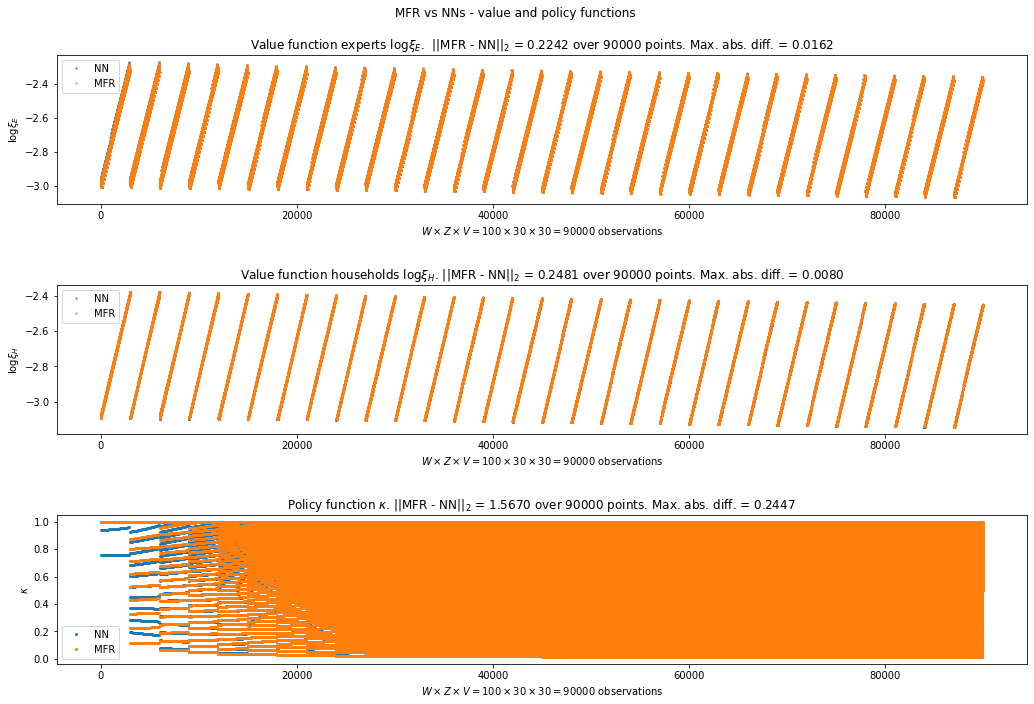

In [ ]:
# Form X and order_states dictionary
X_var = tf.Variable(X, dtype=tf.float64)
order_states           = {'W':0, 'Z': 1, 'V': 2}

logXiE_NNs = logXiE_NN(X_var).numpy().squeeze(axis=1)
logXiH_NNs = logXiH_NN(X_var).numpy().squeeze(axis=1)
kappa_NNs  = kappa_NN(X_var).numpy().squeeze(axis=1)

## Two norms 
twoNormXiE = np.linalg.norm(logXiE_NNs - logXiE)
twoNormXiH = np.linalg.norm(logXiH_NNs - logXiH)
twoNormKappa = np.linalg.norm(kappa_NNs - kappa )

## Max. abs. diff.
maxAbsDiffXiE   = np.max(np.absolute(logXiE_NNs - logXiE))
maxAbsDiffXiH   = np.max(np.absolute(logXiH_NNs - logXiH))
maxAbsDiffKappa = np.max(np.absolute(kappa_NNs - kappa))

mfr_Results   = [logXiE, logXiH, kappa]
nn_Results    = [logXiE_NNs, logXiH_NNs, kappa_NNs]
two_Norms     = [twoNormXiE, twoNormXiH, twoNormKappa]
abs_Diffs     = [maxAbsDiffXiE, maxAbsDiffXiH, maxAbsDiffKappa]
  
helper_functions.generate2DPlots(mfr_Results, nn_Results, two_Norms, abs_Diffs)

In [ ]:
fixed_points  = [14, 14, 14]
helper_functions.generateSurfacePlots(mfr_Results, nn_Results, fixed_points, X)

### Risk prices $\pi$

We can take drerivatives of the trained neural networks and study objects of economic interest such as the risk prices for the households: 

>$$
\pi = \gamma_h \frac{1-\chi \kappa}{1 - w} \sigma_R + (\gamma_h -1)\sigma'_{X}\partial_{X} \ln \xi_h \quad\quad\quad (62)
$$

Below is a comparison between the neural net and finite difference (MFR Suite) approximations.

In [ ]:
Pi_MFR = helper_functions.computeRiskPrices(logXiH_NN, logXiE_NN, kappa_NN, X_var, params, order_states,
             logXiE, logXiH, kappa, dX_LogXiE, dX_LogXiH, dX2_LogXiE, 
             dX2_LogXiH, dX_Q, dX2_Q_diag, dX_logq, dX2_logq, typeOfOutput = 'MFR')

Pi_NN = helper_functions.computeRiskPrices(logXiH_NN, logXiE_NN, kappa_NN, X_var, params, order_states, typeOfOutput = 'NN')

helper_functions.plotRiskPrices(Pi_MFR, Pi_NN, X, fix_V_location=14, fix_Z_location=14)

# Timing comparison

We can perform a timing comparison between the DNN approximation and the finite difference solution from the MFR Suite. Using the `log.txt` file which the MFR Suite outputs we can sum the time for each iteration of the numerical solution algorithm and compute the total approximation time.

As the output suggests, for the economy in question the MFR Suite takes 3 hours and 42 minutes, while the last line of the training output above indicates that the DNN approximation took 10 minutes and 40 seconds. Thus, the deep learing approach is more than 20 times faster. 

In [7]:
# Compute time for MFR solution
import re

with open(folderName + '/' + 'log.txt') as f:
    lines = f.readlines()

total_t = 0.0
for line in lines:
  x = re.search('Iteration .* is completed; time elapsed:', line)
  if x: 
    start = x.span(0)[1] + 1
    end = line[start:].find(';')
    t = line[start:start + end] 
    total_t += float(t)

seconds = total_t
seconds = seconds % (24 * 3600)
hour = seconds // 3600
seconds %= 3600
minutes = seconds // 60
seconds %= 60

print("Time elapsed for MFR solution: %d:%02d:%02d" % (hour, minutes, seconds)) ## Time elapsed for MFR solution: 3:42:36

Time elapsed for MFR solution: 3:42:36
